In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import os
import random

from collections import defaultdict
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,\
                        GlobalAveragePooling2D, UpSampling2D,Concatenate

import tensorflow as tf 
from tensorflow.io import read_file
from tensorflow.io import decode_jpeg

<!DOCTYPE html>
<html>

<body>

<h1><center>Waste Classification</center></h1> 
<h4><center>Vasil Kichukov</center></h4>

</body>
</html>

## Abstract ##

The proper handling of waste is one of the biggest challenges of modern society (Malik & et.al, 2022), as its increasing production poses significant threat to the environment. To address this challenge, prioritizing waste sorting at the initial stage is crucial to maximize recyclable items and minimize irreversible consequences. Despite there are many unprofessional workers being accountable for this task their efforts seem to be time-consuming and less effective as the world created nearly one and a half billion of tons of civil waste every year (Sami, Amin & Hassan, 2020). As per estimation of the World Bank that figure is predicted to hit 2.2 billion of tons by 2025. Hence, people should prioritize the efficacy of forthcoming action plans, given that recycling holds the potential to result in great benefits such as saving 60 million barrels of oil annually and reducing landfill necessities by up to 20%.  Given these needs and the most efficient techniques proposed by researchers so far (Malik & et.al, 2022), the current project aims to develop a working model based on neural networks that will contribute to the more efficient waste management.

### Table of Contents

* [1. Dataset Representation](#Description)
* [2. Reading data](#Reading)
* [3. Visualizing the data](#Visualizing)
* [4. Preprocessing](#Preprocessing)
* [5. Model](#Model)
    * [5.1. Visualize Performance](#Visualize)
* [6. Transform Learning](#Transform)
    * [6.1. Visualize Performance](#Visualize2)
* [7. Conclusion](#Conclusion)
* [8. References](#References)

## Introduction 

The escalating challenge of garbage disposal results from the widespread production of disposable goods across industries, intensifying the waste crisis. Items like plastic-bottled drinking water and takeaway coffee cups exemplify the diverse array of disposable products exacerbating the waste issue (Malik & et.al, 2022. Urgency for effective waste management arises from the crucial need for ecological balance, disrupted significantly over the past two centuries due to human activities.
According to Eurostat report 5.2 tonnes of waste were generated per EU inhabitant in 2018 (Eurosrat, 2018) while World Bank states that only 3.5% of global waste is recycled, while about 33% of garbage is thrown away openly without any preliminary classification (Majchrowska & etl.al, 2022). It could be argued that this waste includes diverse items, from cans and bottles to furniture, electronics, hazardous waste, organic waste, and fast fashion items. 
In essence, embracing a stronger circular economy is not merely an option but a necessity. It offers a sustainable alternative that aligns with the urgent need to rethink our resource consumption and disposal patterns. The possibility of extending the life of plastic lies in its reintroduction into the economy, preventing its accumulation in the environment.Moreover, transitioning to a more robust circular economy is essential for effectively tackling hazardous waste, specifically batteries, thus ensuring protection against potential environmental harm.


## 1. Dataset Representation <a class="anchor" id="Description"></a>

Therefore, the ongoing project employs a diverse dataset featuring images across 12 distinct categories, showcasing a variety of waste materials. These categories span from typical paper and plastic to items linked to the growing concern of fast fashion, such as clothing and shoes, along with those suitable for composting as organic waste. Such datasets can broaden the potential for developing models proficient in categorizing recyclable waste, effectively tackling the challenges posed by the diverse nature of materials within the generated human waste. The dataset contains 12 folders (classes):
* *paper*
* *cardboard*
* *biological*
* *metal*
* *plastic*
* *green-glass*
* *brown-glass*
* *white-glass*
* *shoes*
* *batteries*
* *trash*

## 2. Reading data <a class="anchor" id="Reading"></a>

In [2]:
BASE_DIR = "./data/garbage_classification/"
NUM_CLASSES = 12
IMAGE_WIDTH = 228    
IMAGE_HEIGHT = 228
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SIZE_CHANNELS = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 24

To reduce hardcoding, we'll keep everything in different variables so we can manipulate it more easily if needed.

In [3]:
classes = os.listdir(BASE_DIR)
folder_names = [os.path.join(BASE_DIR, class_name) for class_name in classes]

The function "os.listdir()" retrieves a list of all directories within the directory specified by the BASE_DIR variable, in our case, these are the classes. For each class name, it appends the full path of the directory containing the images for that class to the folder_names list.

In [4]:
all_files = []
all_classes = []

for folder_name, class_name in zip(folder_names, classes):
    files = os.listdir(folder_name)
    all_files.extend([os.path.join(folder_name, file) for file in files])
    all_classes.extend([class_name] * len(files))

We're going through each class folder to find all the image files inside. For each image found, we're saving its full path in a list all_files. At the same time, we're keeping track of which class each image belongs to by adding the class name to another list all_classes.

In [5]:
print(len(all_files),"=",len(all_classes))

15515 = 15515


In [6]:
class_mapping = {class_name: class_id for (class_id, class_name) in list(enumerate(classes))}
class_mapping

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

In [7]:
all_class_ids = [class_mapping[os.path.basename(os.path.dirname(file_path))] for file_path in all_files]

This code makes a dictionary called class_mapping. It matches each class name with a unique class ID. Then, it maps each file to its corresponding class ID based on the directory structure and the provided class_mapping.

## 3. Visualizing the data <a class="anchor" id="Visualizing"></a>

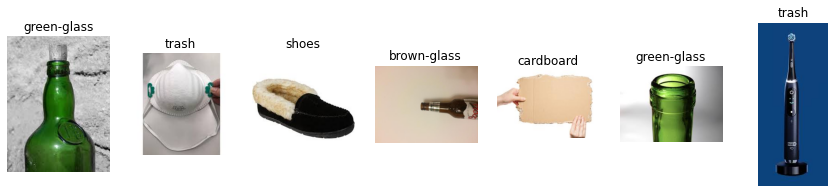

In [8]:
num_samples = 7
random_indices = random.sample(range(len(all_files)), num_samples)
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    img_path = all_files[idx]
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(all_classes[idx])
    axes[i].axis("off")

plt.show()

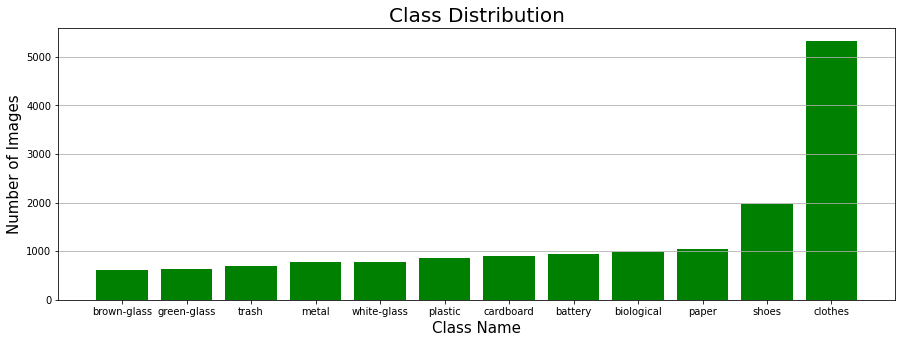

In [9]:
class_counts = {class_name: all_classes.count(class_name) for class_name in set(all_classes)}
sorted_class_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1])}

class_names = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(15, 5))
plt.bar(class_names, counts, color="green")
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.title("Class Distribution", fontsize=20)
plt.grid(axis='y')
plt.show()

In the bar chart above, "clothes" have 5325 samples, and "shoes" have 1977 samples. These two classes contain almost 50% of our data. The other classes are balanced, varying between 600-1000 classes.

## 4. Preprocessing <a class="anchor" id="Preprocessing"></a>

In [10]:
class_to_files = defaultdict(list)
for file_path, class_id in zip(all_files, all_class_ids):
    class_to_files[class_id].append(file_path)

We are createing a dictionary called class_to_files, where each key represents a class ID, and the corresponding value is a list of file paths belonging to that class. This process  organizes the files into classes based on their class IDs.

In [11]:
train_fraction = 0.8
test_fraction = 0.1
val_fraction = 0.1

These variables represent the fractions of the dataset that will be allocated for training(80%), testing(10%), and validation(10%).

In [12]:
train_files = [] 
test_files = []  
val_files = []

train_classes = []
test_classes = []
val_classes = []

We will store the file paths and class labels for the training, testing, and validation sets.

In [13]:
for class_id, files in class_to_files.items():
    num_samples = len(files)
    num_train = int(train_fraction * num_samples)
    num_test = int(test_fraction * num_samples)
    
    train_files.extend(files[:num_train])
    test_files.extend(files[num_train:num_train+num_test])
    val_files.extend(files[num_train+num_test:])
    
    train_classes.extend([class_id] * num_train)
    test_classes.extend([class_id] * num_test)
    val_classes.extend([class_id] * (num_samples - num_train - num_test))

Iterating through each class in class_to_files dictionary and splits the files associated with each class into training, testing, and validation sets based on the defined fractions. Then extends the train_files, test_files, and val_files lists with the corresponding file paths, and train_classes, test_classes, and val_classes lists with the class IDs. 

In [14]:
print("Number of training files:", len(train_files))
print("Number of testing files:", len(test_files))
print("Number of validation files:", len(val_files))

Number of training files: 12409
Number of testing files: 1545
Number of validation files: 1561


In [15]:
def count_labels(files):
    label_counts = defaultdict(int)
    for file_path in files:
        class_name = os.path.basename(os.path.dirname(file_path))
        label_counts[class_name] += 1
    return label_counts

This function is useful for understanding the distribution of class labels in all lists and checking if the split was made correctly.

In [16]:
train_label_counts = count_labels(train_files)
test_label_counts = count_labels(test_files)
val_label_counts = count_labels(val_files)

print("Training Set Label Counts:")
for label, count in train_label_counts.items():
    print(f"{label}: {count}")

print("\nTesting Set Label Counts:")
for label, count in test_label_counts.items():
    print(f"{label}: {count}")

print("\nValidation Set Label Counts:")
for label, count in val_label_counts.items():
    print(f"{label}: {count}")

Training Set Label Counts:
battery: 756
biological: 788
brown-glass: 485
cardboard: 712
clothes: 4260
green-glass: 503
metal: 615
paper: 840
plastic: 692
shoes: 1581
trash: 557
white-glass: 620

Testing Set Label Counts:
battery: 94
biological: 98
brown-glass: 60
cardboard: 89
clothes: 532
green-glass: 62
metal: 76
paper: 105
plastic: 86
shoes: 197
trash: 69
white-glass: 77

Validation Set Label Counts:
battery: 95
biological: 99
brown-glass: 62
cardboard: 90
clothes: 533
green-glass: 64
metal: 78
paper: 105
plastic: 87
shoes: 199
trash: 71
white-glass: 78


In [17]:
def preprocess_image(image_filename, image_class):
    image_file = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(image_file)
    image_scaled = tf.cast(image, float) / 255.0
   
    image_augmented = tf.image.random_flip_left_right(image_scaled)
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    
    image_resized = tf.image.resize(image_augmented, IMAGE_SIZE)
    
    return image_resized, image_class

This function reads an image file, decodes it into a tensor, scales its pixel values to the range [0, 1], resizes it to a predefined size, and returns the resized image tensor along with its corresponding class label.

In [18]:
def create_dataset(files, class_ids):
    dataset = tf.data.Dataset.from_tensor_slices((files, class_ids))
    dataset_shuffled = dataset.shuffle(len(files), seed=50)
    dataset_preprocessed = dataset_shuffled.map(preprocess_image)
    dataset_batched = dataset_preprocessed.batch(BATCH_SIZE).repeat()
    
    return dataset_batched

We are creating a TensorFlow dataset from a list of image file paths and their corresponding class IDs. It shuffles the dataset, applies a preprocessing function to each image, batches the data for training, and repeats the dataset indefinitely for multiple epochs.

In [19]:
train_dataset = create_dataset(train_files, train_classes)
val_dataset = create_dataset(val_files, val_classes)
test_dataset = create_dataset(test_files, test_classes)

Each TensorFlow dataset is prepared for training, validation, and testing respectively, following the same preprocessing steps.

In [20]:
for el in train_dataset.take(1):
    print(el[0].shape)
    print(el[1].shape)
    print(el[1].numpy())
    print(el[0].numpy())

(24, 228, 228, 3)
(24,)
[ 9  4 11  1  4  4  6 11  0  2  4  5  8  4  4  5  4  5  7  8  3  5 11  4]
[[[[0.2524596  0.23677331 0.2250086 ]
   [0.2652151  0.24952883 0.2377641 ]
   [0.25825596 0.24256966 0.23080495]
   ...
   [0.09803922 0.08235294 0.07058824]
   [0.10015486 0.08446859 0.07270388]
   [0.11443063 0.09874436 0.08697965]]

  [[0.25830755 0.24262126 0.23085655]
   [0.27190948 0.2562232  0.24445847]
   [0.2675262  0.25183994 0.24007523]
   ...
   [0.10196079 0.08627451 0.07450981]
   [0.10407643 0.08839016 0.07662545]
   [0.1183522  0.10266592 0.09090122]]

  [[0.2514276  0.23574132 0.22397661]
   [0.26131797 0.2456317  0.23386699]
   [0.26711386 0.2514276  0.23966289]
   ...
   [0.10543516 0.08974888 0.07798418]
   [0.1075508  0.09186453 0.08009982]
   [0.12182657 0.10614029 0.09437559]]

  ...

  [[0.2928795  0.22229123 0.17523241]
   [0.30665624 0.236068   0.18900917]
   [0.30280337 0.23221514 0.18515632]
   ...
   [0.31659582 0.26169387 0.21071348]
   [0.29437435 0.23947237

## 5. Model <a class="anchor" id="Model"></a>

In [21]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((3, 3)),
        Dropout(0.5),
        Flatten(),
        Dense(250, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model


cnn_model = create_cnn_model(IMAGE_SIZE_CHANNELS, NUM_CLASSES)

cnn_model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 flatten (Flatten)           (None, 350464)            0         
                                                                 
 dense (Dense)               (None, 250)               87616250  
                                                        

This architecture was proposed in the article [CNN Model: Trash Classification](https://www.researchgate.net/publication/346937517_Trash_Classification_Classifying_garbage_using_Deep_Learning):

● Layer 1 called as Conv2d layer convolves the images using 32 filters each size of 3*3.

● Layer 2 again Conv2D layer also used as convolve the images and using 64 filters each size of 3*3.

● Layer 3 is MaxPooling2D layer picks the max value in a matrix of size of 3*3.

● Layer 4 is Dropout at a rate of 0.5.

● Layer 5 is flattening the output from layer 4 and this flatten passed to layer6.

● Layer 6 is a hidden layer of the network containing 250 neurons.

● Layer 7 is an output layer consisting of 12 neurons of 12 types of output using soft max function.

Model Compilation: After creating the model, it is compiled using the Adam optimizer, sparse categorical crossentropy loss (suitable for integer labels), and accuracy as the evaluation metric.

In [22]:
early_stop = EarlyStopping(
    patience=1, 
    verbose=1, 
    monitor="val_accuracy", 
    mode="max", 
    min_delta=0.001, 
    restore_best_weights=True
)

callbacks = [early_stop]

The EarlyStopping callback is used to halt the training process when a monitored quantity, such as validation accuracy, stops improving.

In [23]:
train_steps_per_epoch = len(train_files) // BATCH_SIZE
val_steps_per_epoch = len(val_files) // BATCH_SIZE

Number of steps per epoch for training and validation data. It divides the total number of samples in the training and validation sets by the batch size to determine how many batches are needed to cover all samples in one epoch of training or validation

In [24]:
training_cnn = cnn_model.fit(
    train_dataset,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/20
517/517 [==============================] - 788s 2s/step - loss: 1.6935 - accuracy: 0.5260 - val_loss: 1.2778 - val_accuracy: 0.5968
Epoch 2/20
517/517 [==============================] - 794s 2s/step - loss: 1.0312 - accuracy: 0.6536 - val_loss: 1.1931 - val_accuracy: 0.6135
Epoch 3/20
517/517 [==============================] - 792s 2s/step - loss: 0.8693 - accuracy: 0.7105 - val_loss: 1.1306 - val_accuracy: 0.6455
Epoch 4/20
517/517 [==============================] - 786s 2s/step - loss: 0.7503 - accuracy: 0.7523 - val_loss: 1.1603 - val_accuracy: 0.6429
Epoch 4: early stopping


The training dataset containing batches of input data and corresponding labels.
The validation dataset containing batches of input data and corresponding labels used to evaluate the model **after each epoch**.

In [25]:
test_loss, test_accuracy = cnn_model.evaluate(test_dataset, steps=len(test_files) // BATCH_SIZE)
print("Test Accuracy:", test_accuracy)

64/64 [==============================] - 14s 223ms/step - loss: 1.0587 - accuracy: 0.6777
Test Accuracy: 0.677734375


### 5.1 Visualize Performance <a class="anchor" id="Visualize"></a>

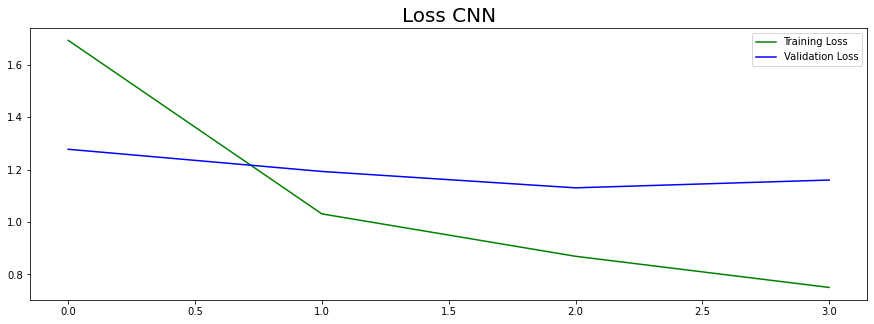

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(training_cnn.history["loss"], color="green", label="Training Loss")
ax.plot(training_cnn.history["val_loss"], color="blue", label="Validation Loss")
ax.set_title("Loss CNN", fontsize=20)
ax.legend(loc="upper right")
plt.show()

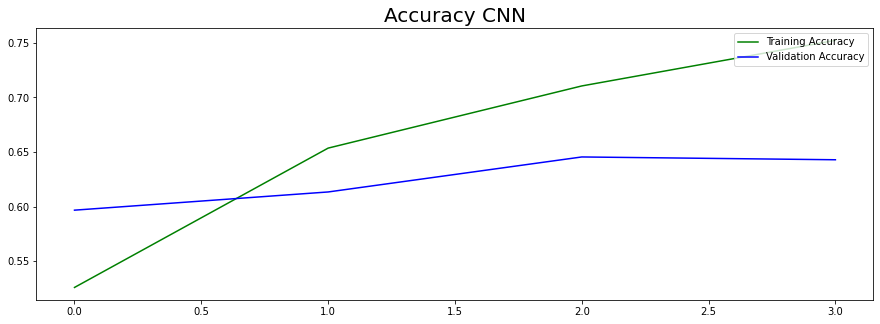

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(training_cnn.history["accuracy"], color="green", label="Training Accuracy")
ax.plot(training_cnn.history["val_accuracy"], color="blue", label="Validation Accuracy")
ax.set_title("Accuracy CNN", fontsize=20)
ax.legend(loc="upper right")
plt.show()

After trying different approaches - such as changing the batch size, changing the number of iterations per epoch, and changing the optimization function, we can conclude that the best option is to work with a relatively medium batch size and stop a little early, in this case, it remains "patience=1". Our algorithm stops at the first epoch in which we have a result worse than the previous one and takes the best weight coefficients up to that point. After the third epoch, the loss function of the validation data remains stable and the model accuracy does not increase. Also, the gap between accuracy and val_accuracy after the third epoch increases. The training stops early at epoch 4 due to the EarlyStopping callback, suggesting that the model's performance on the validation set did not improve significantly after epoch 3, confirming the presence of overfitting.

## 6. Transform Learning  <a class="anchor" id="Transform"></a>

InceptionV3 is a powerful CNN developed by Google, excelling in image recognition tasks. Its unique design, incorporating inception modules, enables efficient feature extraction across different spatial scales. Transfer learning with InceptionV3 offers several benefits for waste detection:

Feature Extraction: Pre-trained on ImageNet, InceptionV3 learns diverse features beneficial for waste detection, even with limited data.

High-Level Abstractions: Its architecture captures intricate patterns crucial for identifying various waste materials with diverse characteristics.

Efficient Training: Transfer learning with InceptionV3 requires fewer computational resources and less time, advantageous for resource-constrained environments.

Leveraging InceptionV3's pre-trained weights and architecture, transfer learning facilitates superior waste detection performance, overcoming data limitations. 

In [29]:
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=IMAGE_SIZE_CHANNELS
)

base_model.trainable = False

model_iv3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

model_iv3.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

●  Base Model Initialization: The InceptionV3 model is loaded with pre-trained weights from ImageNet but without the top classification layers (include_top=False). This allows leveraging the learned features while excluding the final classification layers

●  Freezing Base Model Weights: The base model's trainable parameters are set to False to prevent them from being updated during training. This ensures that only the added classification layers are trained while keeping the pre-trained weights intact 

●  Model Definition: Additional layers, including a GlobalAveragePooling2D layer to reduce spatial dimensions and a Dense layer with softmax activation for classification, are appended to the base model within a Sequential model structure

In [30]:
training_iv3 = model_iv3.fit(
    train_dataset,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/20
517/517 [==============================] - 248s 469ms/step - loss: 0.5206 - accuracy: 0.8395 - val_loss: 0.4585 - val_accuracy: 0.8564
Epoch 2/20
517/517 [==============================] - 237s 458ms/step - loss: 0.3082 - accuracy: 0.9015 - val_loss: 0.3926 - val_accuracy: 0.8795
Epoch 3/20
517/517 [==============================] - 230s 446ms/step - loss: 0.2543 - accuracy: 0.9152 - val_loss: 0.4078 - val_accuracy: 0.8647
Epoch 3: early stopping


In [31]:
test_loss, test_accuracy = model_iv3.evaluate(test_dataset, steps=len(test_files) // BATCH_SIZE)
print("Test Accuracy:", test_accuracy)

64/64 [==============================] - 28s 435ms/step - loss: 0.3661 - accuracy: 0.8802
Test Accuracy: 0.8802083134651184


### 6.1 Visualize Performance <a class="anchor" id="Visualize2"></a>

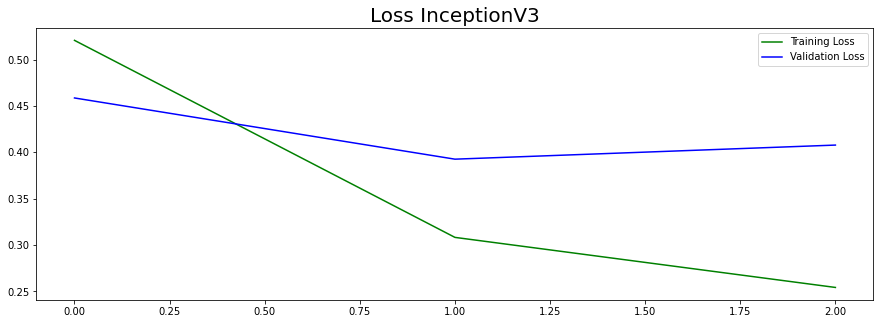

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(training_iv3.history["loss"], color="green", label="Training Loss")
ax.plot(training_iv3.history["val_loss"], color="blue", label="Validation Loss")
ax.set_title("Loss InceptionV3", fontsize=20)
ax.legend(loc="upper right")
plt.show()

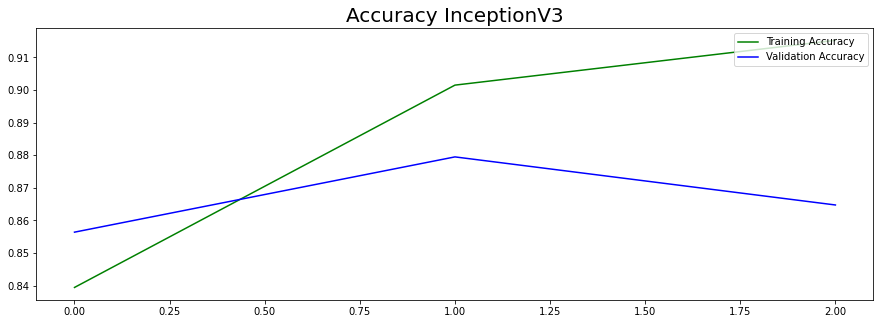

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(training_iv3.history["accuracy"], color="green", label="Training Accuracy")
ax.plot(training_iv3.history["val_accuracy"], color="blue", label="Validation Accuracy")
ax.set_title("Accuracy InceptionV3", fontsize=20)
ax.legend(loc="upper right")
plt.show()

## 7. Conclusion <a class="anchor" id="Conclusion"></a>

Both CNNs and InceptionV3 have demonstrated strong capabilities in image classification, with CNNs offering flexibility and optimization options for high accuracy, while InceptionV3's advanced architecture, including inception modules, captures complex features effectively. Autoencoders, especially denoising or variational types, enhance model robustness through unsupervised learning, improving generalization and handling noisy data. Additionally, autoencoders aid in dimensionality reduction, potentially streamlining training and reducing overfitting. Integrating autoencoder-based unsupervised learning methods in future iterations promises to enhance the model's performance and robustness.

Therefore, the project stands open for further development.

## 8. References <a class="anchor" id="References"></a>

* [Dataset: Garbage Classification (12 classes)](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)
* [Eurostat: European household waste collection](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Waste_statistics)
* [Deep learning-based waste detection](https://www.sciencedirect.com/science/article/pii/S0956053X21006474)
* [Waste Classification for Sustainable Development](https://www.mdpi.com/2071-1050/14/12/7222)
* [Waste Management](https://journals.iium.edu.my/kict/index.php/IJPCC/article/view/165)
* [CNN Model: Trash Classification](https://www.researchgate.net/publication/346937517_Trash_Classification_Classifying_garbage_using_Deep_Learning)
* [Waste classification using transfer learning](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/12804/128040K/Municipal-solid-waste-classification-using-transfer-learning/10.1117/12.2687046.short)